In [16]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns



from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.cluster import DBSCAN, KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler


from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
####################################################
# Load the data
df = pd.read_csv("n/full_data_flightdelay.csv.xz", compression='xz')
# df = pd.read_csv("test.csv.xz", compression='xz')
#print(df.head())

# take a random sample of 1000 rows
df = df.sample(n=10000)

ontime = df[df['DEP_DEL15'] == 0]
delayed = df[df['DEP_DEL15'] == 1]

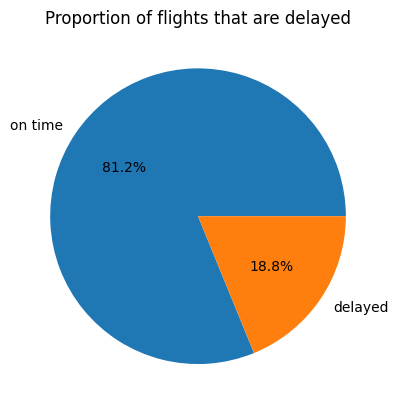

In [2]:
plt.pie(df['DEP_DEL15'].value_counts(), labels=['on time', 'delayed'], autopct='%1.1f%%')
plt.title('Proportion of flights that are delayed')
plt.show()

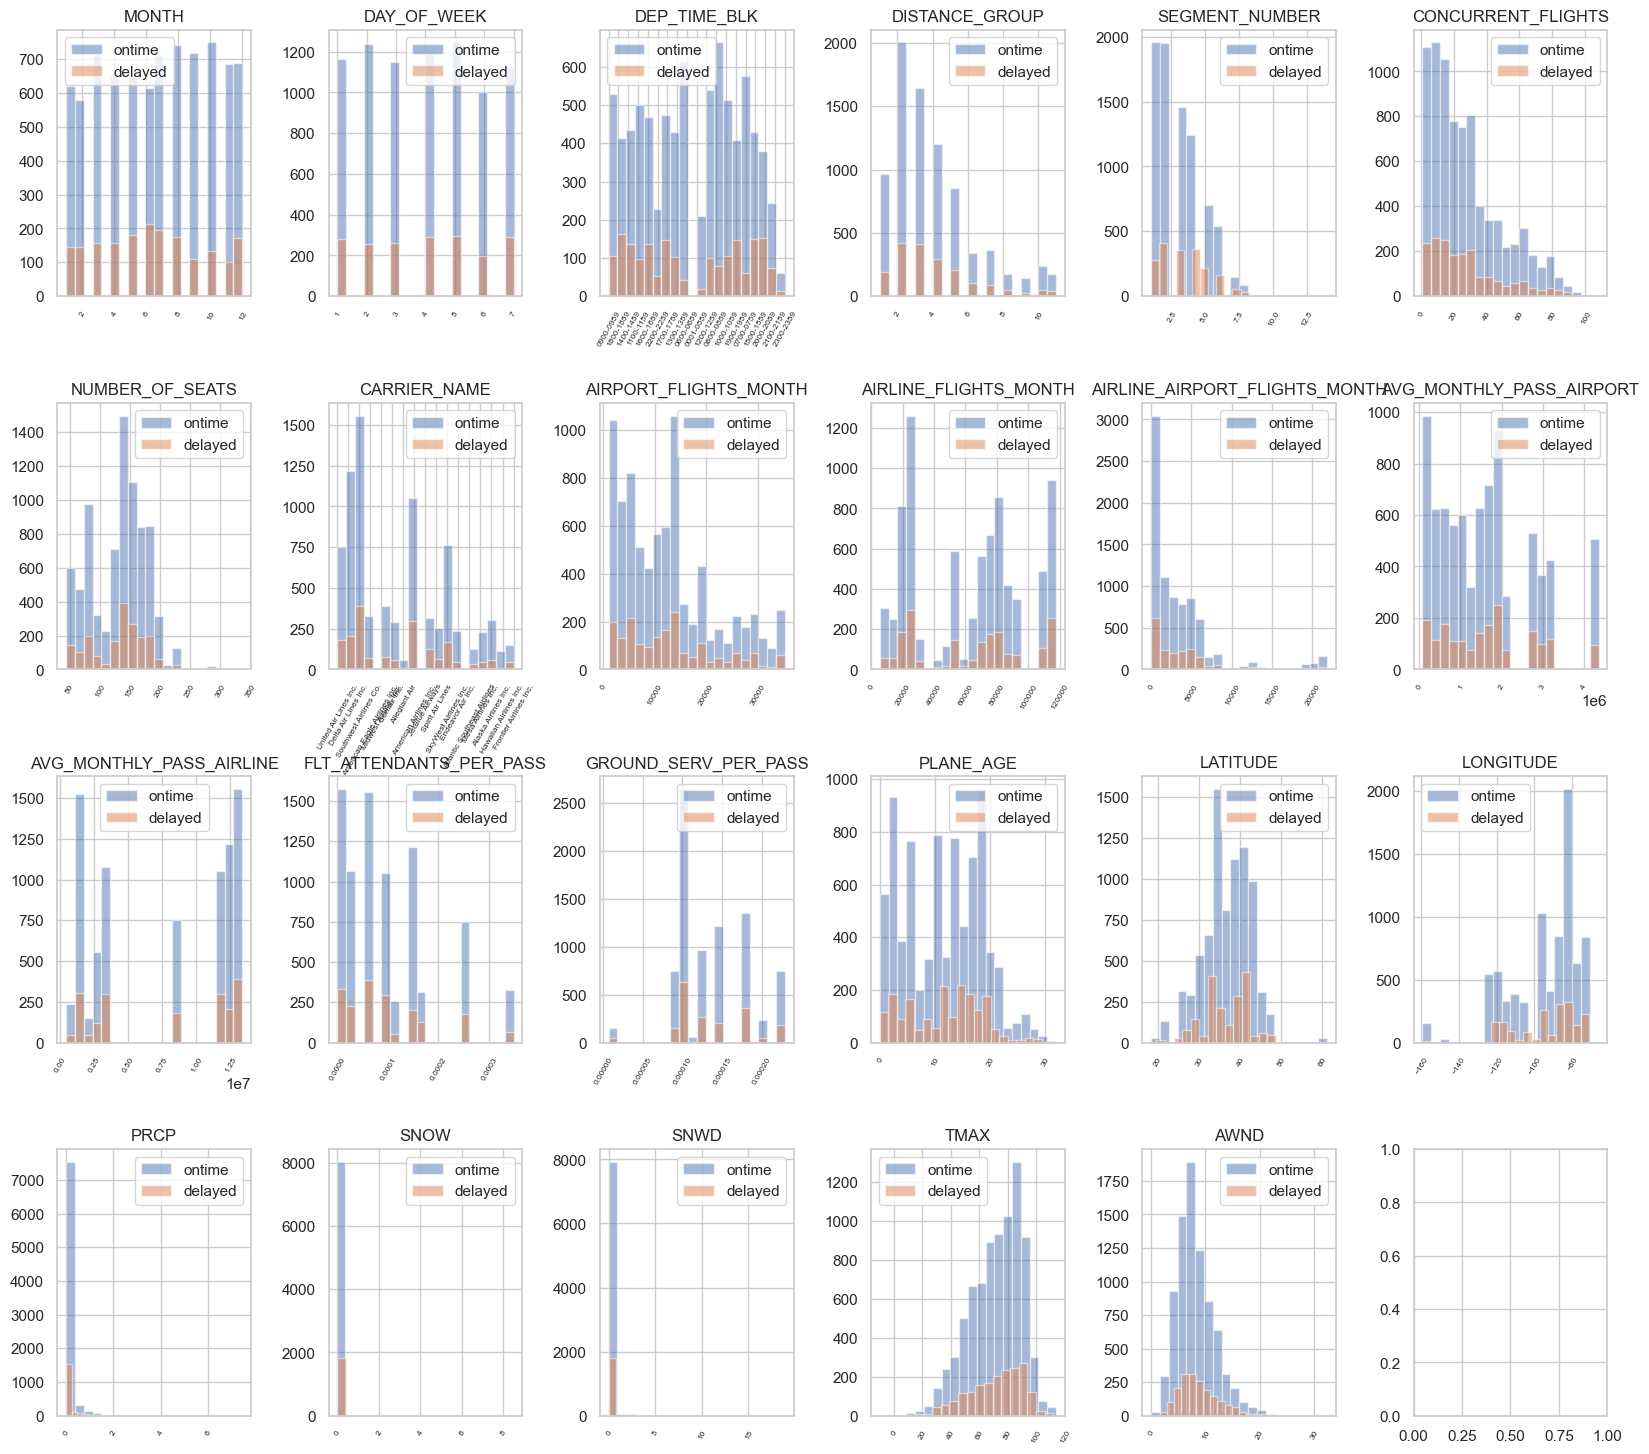

In [13]:
# Inital EDA
# Plot the columns of the ontime and delayed flights and compare, put all the plots in the same figure
# Create a figure with 5 rows and 6 columns which are well spaced

plot_ontime = ontime.copy()
plot_delayed = delayed.copy()

plot_ontime = plot_ontime.drop(columns=['DEP_DEL15', 'DEPARTING_AIRPORT', 'PREVIOUS_AIRPORT'])
plot_delayed = plot_delayed.drop(columns=['DEP_DEL15', 'DEPARTING_AIRPORT', 'PREVIOUS_AIRPORT'])

fig, axs = plt.subplots(4, 6, figsize=(20, 18))

for i, col in enumerate(plot_ontime.columns):
    ax = axs[i//6, i%6]
    ax.hist(plot_ontime[col], alpha=0.5, label='ontime', bins=20)
    ax.hist(plot_delayed[col], alpha=0.5, label='delayed', bins=20)
    ax.tick_params(axis='x', rotation=60, labelsize=6)
    ax.set_title(col)
    ax.legend()
plt.subplots_adjust(wspace=0.4, hspace=0.4)
# plt.savefig('flights.png')
plt.show()

In [17]:
# Print airports with the most delayed flights
delayed_airports = df[df['DEP_DEL15'] == 1]
delayed_airports = delayed_airports['DEPARTING_AIRPORT'].value_counts()
delayed_airports = delayed_airports.sort_values(ascending=False)
print(delayed_airports)

DEPARTING_AIRPORT
Chicago O'Hare International    122
Dallas Fort Worth Regional      116
Atlanta Municipal                92
Stapleton International          81
Douglas Municipal                65
                               ... 
Rochester Monroe County           1
Keahole                           1
El Paso International             1
Spokane International             1
Kahului Airport                   1
Name: count, Length: 93, dtype: int64


In [4]:
# DATA CLEANING
# encode the categorical data
le = LabelEncoder()

def clean_labels_encoder(list_of_labels, df):
    for label in list_of_labels:
        df[label] = le.fit_transform(df[label])
    return df

# clean the labels
list_of_labels = ['CARRIER_NAME', 'DEPARTING_AIRPORT', 'PREVIOUS_AIRPORT', 'DEP_TIME_BLK']
df = clean_labels_encoder(list_of_labels, df)

# Drop the columns that are not needed
# df = df.drop(['CARRIER_HISTORICAL', 'DEP_AIRPORT_HIST', 'DAY_HISTORICAL',
#        'DEP_BLOCK_HIST'], axis=1)

# Fill the missing values
df.fillna(df.mean(), inplace=True)

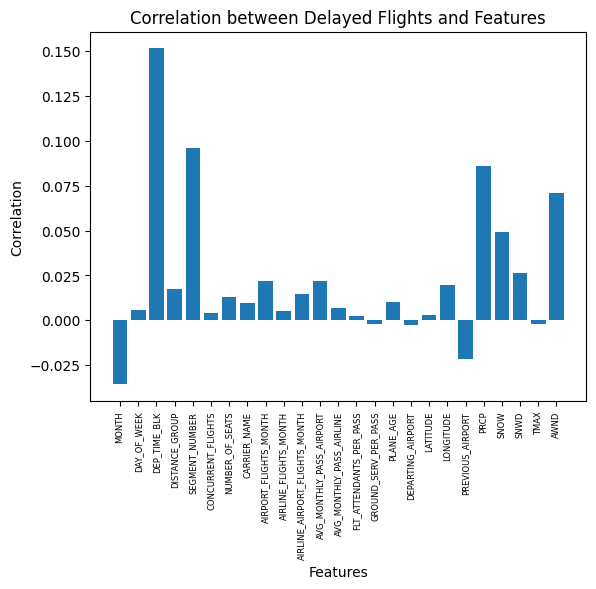

DEP_TIME_BLK                     0.151541
SEGMENT_NUMBER                   0.096164
PRCP                             0.085860
AWND                             0.070658
SNOW                             0.048942
SNWD                             0.026354
AIRPORT_FLIGHTS_MONTH            0.021982
AVG_MONTHLY_PASS_AIRPORT         0.021980
LONGITUDE                        0.019621
DISTANCE_GROUP                   0.017257
AIRLINE_AIRPORT_FLIGHTS_MONTH    0.014756
NUMBER_OF_SEATS                  0.012827
PLANE_AGE                        0.010402
CARRIER_NAME                     0.009507
AVG_MONTHLY_PASS_AIRLINE         0.007080
DAY_OF_WEEK                      0.005593
AIRLINE_FLIGHTS_MONTH            0.005345
CONCURRENT_FLIGHTS               0.004309
LATITUDE                         0.003055
FLT_ATTENDANTS_PER_PASS          0.002543
TMAX                            -0.002093
GROUND_SERV_PER_PASS            -0.002144
DEPARTING_AIRPORT               -0.002682
PREVIOUS_AIRPORT                -0

In [5]:
# FEATURE ENGINEERING
# Calculate the correlation between DEP_DEL15 and the other columns
numeric_cols = df.select_dtypes(include=[np.number]).columns
correlation = df[numeric_cols].corr()['DEP_DEL15']
correlation = correlation.drop(['DEP_DEL15'])


#print(correlation)

# Plot the correlation
plt.bar(correlation.index, correlation)
plt.xticks(rotation=90)
plt.tick_params(axis='x', rotation=90, labelsize=6)
plt.ylabel('Correlation')
plt.xlabel('Features')
plt.title("Correlation between Delayed Flights and Features")
plt.show()


# Sort the correlation
correlation = correlation.sort_values(ascending=False)
print(correlation)

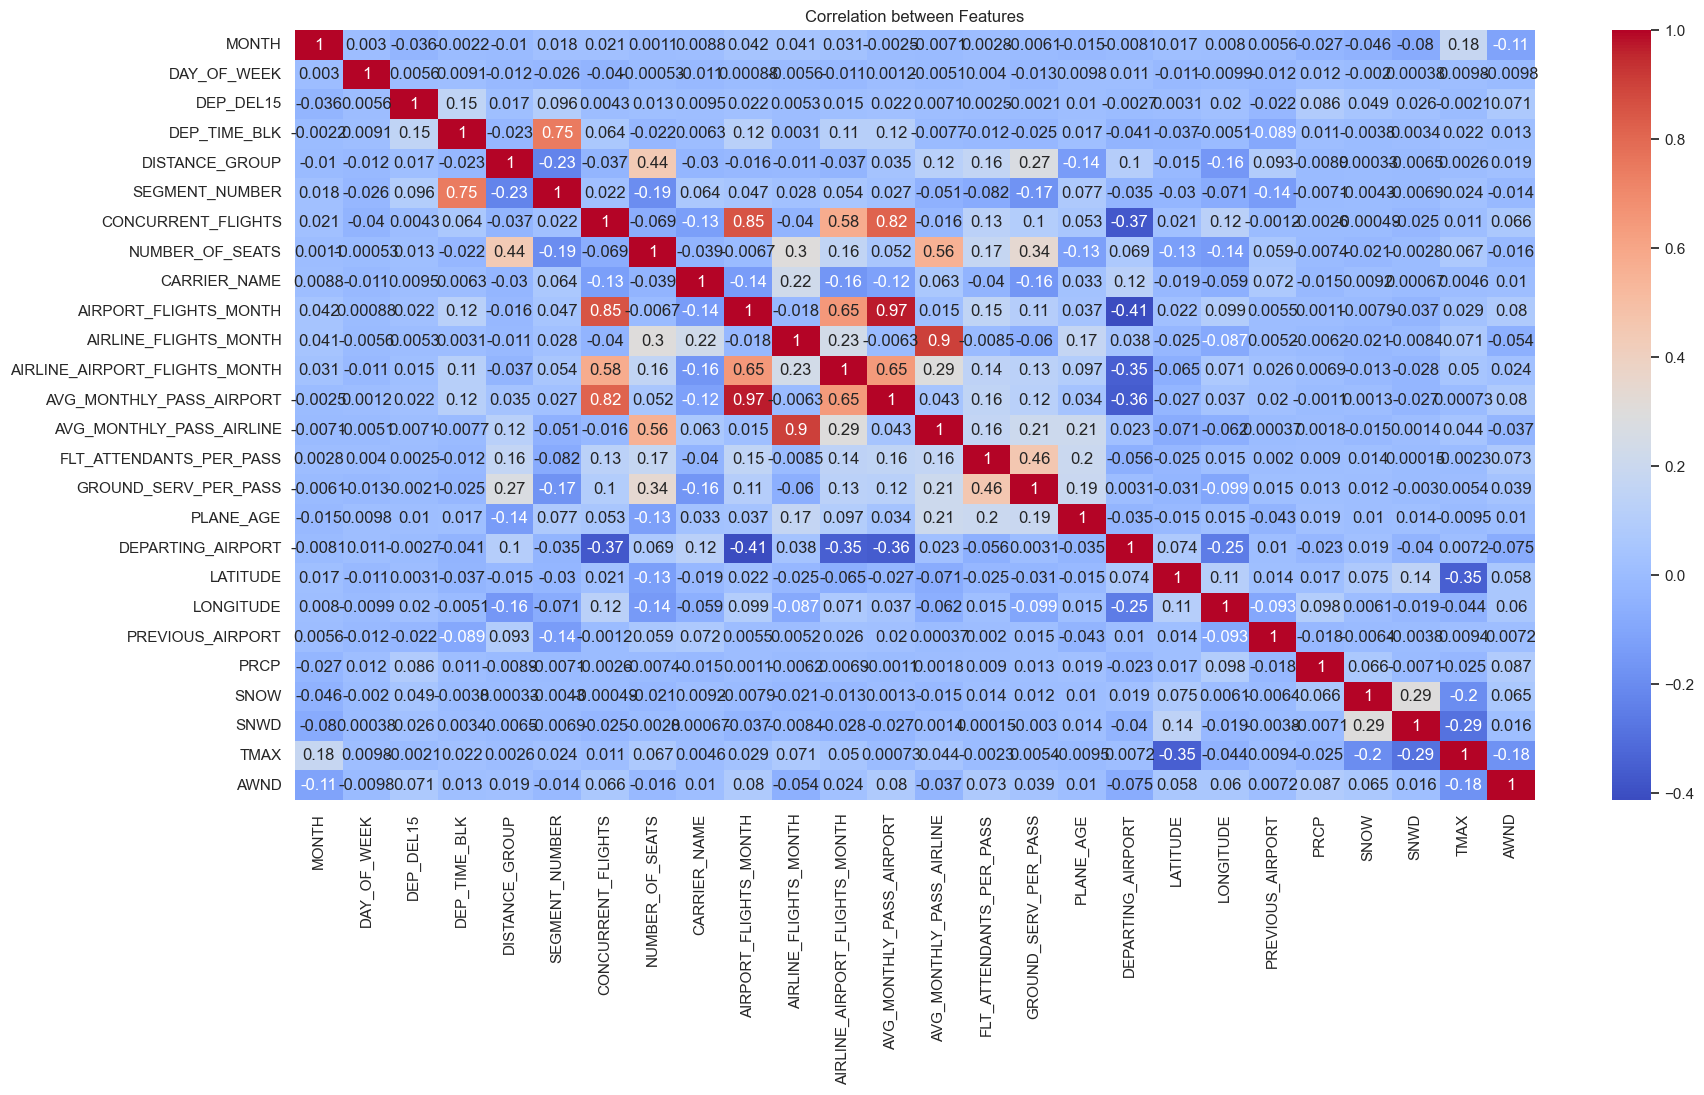

In [6]:
def plot_heatmap(df):
    plt.figure(figsize=(20, 10))
    sns.set_theme(style='whitegrid', context='notebook')
    cols = [0, 1, 2]
    sns.heatmap(df.corr(), annot=True, square=False, cmap='coolwarm')
    plt.title('Correlation between Features')
    plt.show()

plot_heatmap(df)

C:\Users\Fraser\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\cartopy\io\__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
C:\Users\Fraser\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\cartopy\io\__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
C:\Users\Fraser\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\cartopy\io\__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_1_states_provinces_lakes.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


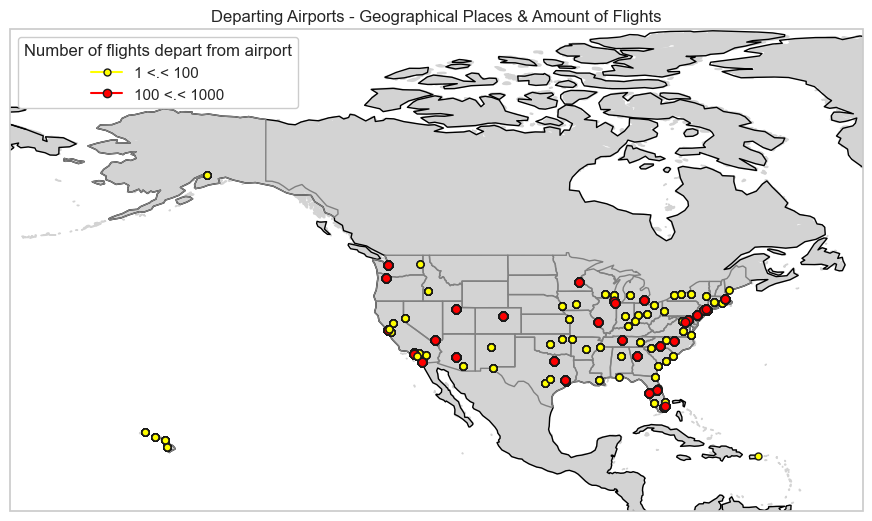

In [14]:
import cartopy
import cartopy.crs as ccrs
from cartopy.feature import NaturalEarthFeature, STATES
from collections import OrderedDict
airports = df[['LONGITUDE', 'LATITUDE', 'DEPARTING_AIRPORT']]

count_flights = df["DEPARTING_AIRPORT"].value_counts()

plt.figure(figsize=(11, 11))
ax = plt.axes(projection=ccrs.PlateCarree())

# Define properties of markers and labels
colors = ['yellow', 'red', 'lightblue', 'purple']
size_limits = [1, 100, 1000, 10000, 100000]
labels = []

# Generate labels for legend
for i in range(len(size_limits) - 1):
    label = f"{size_limits[i]} <.< {size_limits[i+1]}"
    labels.append(label)

# Add map features
ax.add_feature(NaturalEarthFeature('physical', 'land', '50m', edgecolor='face', facecolor='lightgray'))
ax.coastlines()
ax.add_feature(STATES, edgecolor='gray')
ax.set_extent([-180, -50, 10, 75])

# Plot airports on map
for index, row in airports.iterrows():
    flight_count = count_flights[row['DEPARTING_AIRPORT']]
    isize = []
    for i, val in enumerate(size_limits):
        if val < flight_count:
            isize.append(i)
    ind = isize[-1] if isize else 0  # default to smallest if no flights
    ax.plot(row['LONGITUDE'], row['LATITUDE'], marker='o', markersize=ind + 5, color=colors[ind],
            markeredgewidth=1, markeredgecolor='k', transform=ccrs.Geodetic(), label=labels[ind])

# Remove duplicate labels and set their order
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
key_order = [f"{size_limits[i]} <.< {size_limits[i+1]}" for i in range(len(size_limits) - 1)]
new_label = OrderedDict((key, by_label[key]) for key in key_order if key in by_label)
plt.title("Departing Airports - Geographical Places & Amount of Flights")
plt.legend(new_label.values(), new_label.keys(), loc='upper left', prop={'size': 11},
           title='Number of flights depart from airport', frameon=True, framealpha=1)

plt.show()

DEPARTING_AIRPORT
11    117
14     99
4      95
86     80
18     77
     ... 
80      1
60      1
89      1
16      1
35      1
Name: count, Length: 92, dtype: int64
